# GradCAM Visualization Demo with VGG16


In [1]:
# Replace vanila relu to guided relu to get guided backpropagation.
import tensorflow as tf

from tensorflow.python.framework import ops
from tensorflow.python.ops import gen_nn_ops

@ops.RegisterGradient("GuidedRelu")
def _GuidedReluGrad(op, grad):
    return tf.select(0. < grad, gen_nn_ops._relu_grad(grad, op.outputs[0]), tf.zeros(grad.get_shape()))

/home/john/Documents/gradCAM_tensorflow/model/vgg16.npy
npy file loaded
build model started
build model finished: 0s
Top1:  n02108089 boxer 0.420142
Top5:  [('n02108089 boxer', 0.42014152), ('n02108422 bull mastiff', 0.28162268), ('n02123159 tiger cat', 0.053449955), ('n02129604 tiger, Panthera tigris', 0.050134838), ('n02109047 Great Dane', 0.04980772)]


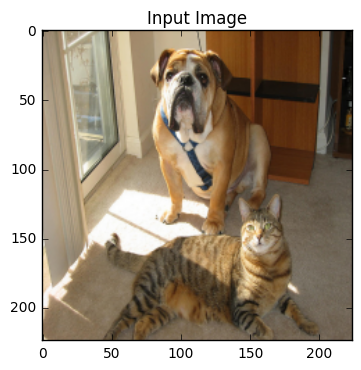

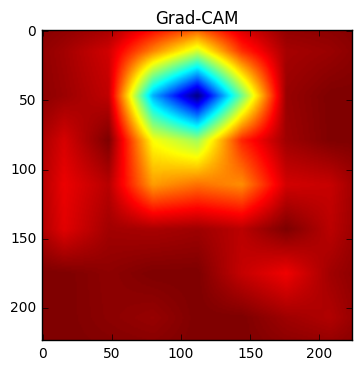

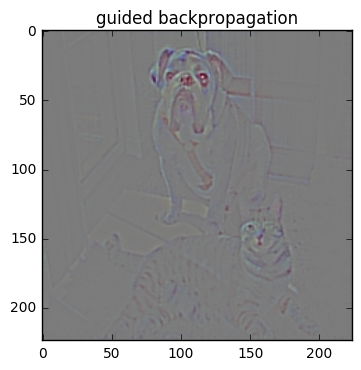

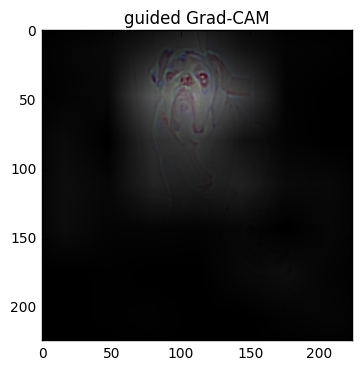

Top1:  n02086240 Shih-Tzu 0.748966
Top5:  [('n02086240 Shih-Tzu', 0.74896568), ('n02098413 Lhasa, Lhasa apso', 0.20148376), ('n02086646 Blenheim spaniel', 0.021774856), ('n02086079 Pekinese, Pekingese, Peke', 0.015152379), ('n02097474 Tibetan terrier, chrysanthemum dog', 0.0022452387)]


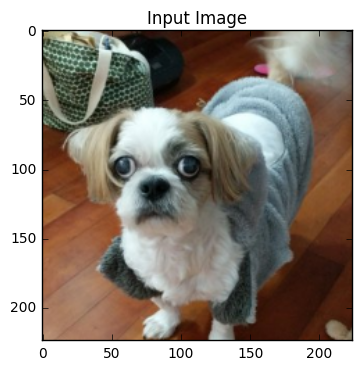

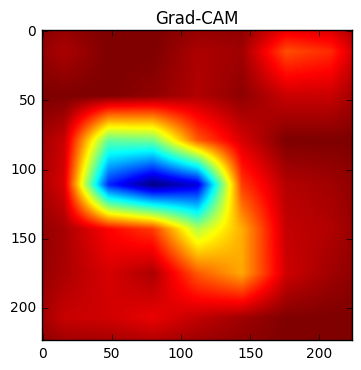

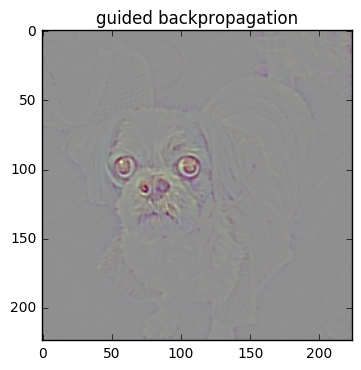

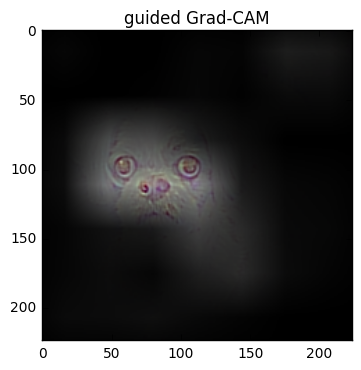

Top1:  n02129604 tiger, Panthera tigris 0.82099
Top5:  [('n02129604 tiger, Panthera tigris', 0.82099038), ('n02123159 tiger cat', 0.17724575), ('n02128925 jaguar, panther, Panthera onca, Felis onca', 0.0012660659), ('n02127052 lynx, catamount', 0.00020411435), ('n02128385 leopard, Panthera pardus', 0.00016284313)]


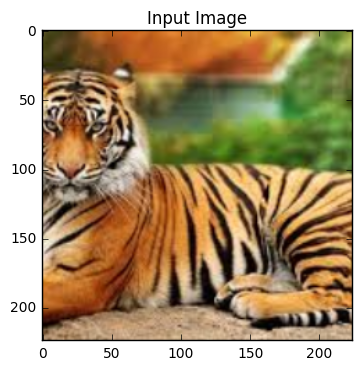

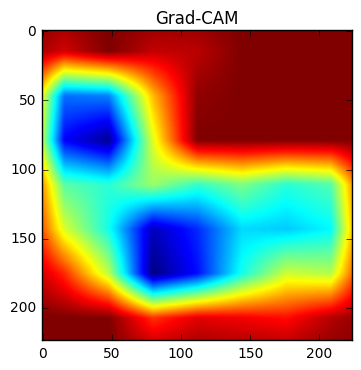

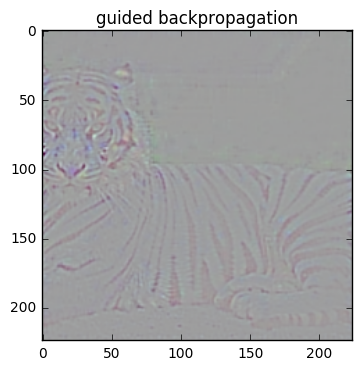

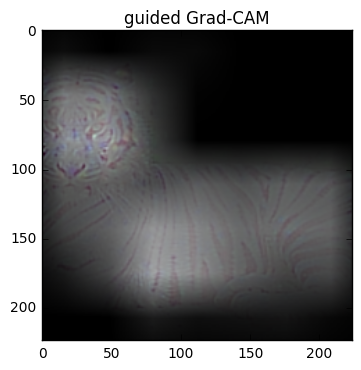

In [26]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
from model import vgg16
import utils

# Create mini-batch for demo

img1 = utils.load_image("./demo.png")
img2 = utils.load_image("./shihtzu_mypuppy.jpg")
img3 = utils.load_image("./tiger.jpg")

batch1_img = img1.reshape((1, 224, 224, 3))
batch1_label = np.array([1 if i == 244 else 0 for i in range(1000)])  # 1-hot result for Boxer
batch1_label = batch1_label.reshape(1, -1)

batch2_img = img2.reshape((1, 224, 224, 3))
batch2_label = np.array([1 if i == 157 else 0 for i in range(1000)])  # 1-hot result for Shih-Tzu
batch2_label = batch2_label.reshape(1, -1)

batch3_img = img3.reshape((1, 224, 224, 3))
batch3_label = np.array([1 if i == 292 else 0 for i in range(1000)])  # 1-hot result for tiger
batch3_label = batch3_label.reshape(1, -1)

batch_img = np.concatenate((batch1_img, batch2_img, batch3_img), 0)
batch_label = np.concatenate((batch1_label, batch2_label, batch3_label), 0)

batch_size = 3


# Create tensorflow graph for evaluation
eval_graph = tf.Graph()
with eval_graph.as_default():
    with eval_graph.gradient_override_map({'Relu': 'GuidedRelu'}):
    
        images = tf.placeholder("float", [batch_size, 224, 224, 3])
        labels = tf.placeholder(tf.float32, [batch_size, 1000])
        train_mode = tf.placeholder(tf.bool)

        vgg = vgg16.Vgg16()
        
        vgg.build(images, train_mode)
        cost = tf.reduce_sum((vgg.prob - labels) ** 2)
        train = tf.train.GradientDescentOptimizer(0.0001).minimize(cost)

        # Get last convolutional layer gradient for generating gradCAM visualization
        target_conv_layer = vgg.pool5
        target_conv_layer_grad = tf.gradients(cost, target_conv_layer)[0]

        # Guided backpropagtion back to input layer
        gb_grad = tf.gradients(cost, images)[0]

        # Normalizing the gradients    
        target_conv_layer_grad_norm = tf.div(target_conv_layer_grad, tf.sqrt(tf.reduce_mean(tf.square(target_conv_layer_grad))) + tf.constant(1e-5))


        init = tf.global_variables_initializer()

        
# Run tensorflow 

with tf.Session(graph=eval_graph) as sess:    
    sess.run(init)
    
    prob = sess.run(vgg.prob, feed_dict={images: batch_img, train_mode: False})
    
    gb_grad_value, target_conv_layer_value, target_conv_layer_grad_value = sess.run([gb_grad, target_conv_layer, target_conv_layer_grad_norm], feed_dict={images: batch_img, labels: batch_label, train_mode: True})
    
    for i in range(batch_size):
        utils.print_prob(prob[i], './synset.txt')
        utils.visualize(batch_img[i], target_conv_layer_value[i], target_conv_layer_grad_value[i], gb_grad_value[i])
    